In [12]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor

## Get Rewards Data

In [13]:
def get_data(task):
    if task == "can":
        rewards_calib = np.load("results/can/20231023-221535/reward_array.npy")
        rewards_id = np.load("results/can/20231130-111845/reward_array.npy")

        first_1000 = np.load("results/can/20231031-171252/reward_array.npy")
        second_1000 = np.load("results/can/20231203-202805/reward_array.npy")
        third_1000 = np.load("results/can/20231212-210747/reward_array.npy")
        fourth_1000 = np.load("results/can/20231216-110713/reward_array.npy")
        rewards_conf = np.vstack((first_1000, second_1000, third_1000, fourth_1000))

    elif task == "lift":
        rewards_calib = np.load("results/lift/20231024-090916/reward_array.npy")
        rewards_id = np.load("results/lift/20231130-205904/reward_array.npy")

        first_1000 = np.load("results/lift/20231101-080157/reward_array.npy")
        second_1000 = np.load("results/lift/20231204-111548/reward_array.npy")
        third_1000 = np.load("results/lift/20231213-072340/reward_array.npy")
        fourth_1000 = np.load("results/lift/20231217-133544/reward_array.npy")
        rewards_conf = np.vstack((first_1000, second_1000, third_1000, fourth_1000))

    elif task == "square":
        rewards_calib = np.load("results/square/20231024-202730/reward_array.npy")
        rewards_id = np.load("results/square/20231201-083641/reward_array.npy")

        first_1000 = np.load("results/square/20231101-204443/reward_array.npy")
        second_1000 = np.load("results/square/20231204-204536/reward_array.npy")
        third_1000 = np.load("results/square/20231213-180353/reward_array.npy")
        fourth_1000 = np.load("results/square/20231218-170050/reward_array.npy")
        rewards_conf = np.vstack((first_1000, second_1000, third_1000, fourth_1000))

    elif task == "tool_hang":
        rewards_calib = np.load("results/tool_hang/20231026-074805/reward_array.npy")
        rewards_id = np.load("results/tool_hang/20231201-201152/reward_array.npy")

        first_1000 = np.load("results/tool_hang/20231104-122712/reward_array.npy")
        second_1000 = np.load("results/tool_hang/20231205-081001/reward_array.npy")
        third_1000 = np.load("results/tool_hang/20231214-081956/reward_array.npy")
        fourth_1000 = np.load("results/tool_hang/20231219-094335/reward_array.npy")
        rewards_conf = np.vstack((first_1000, second_1000, third_1000, fourth_1000))

    elif task == "transport":
        rewards_calib = np.load("results/transport/20231028-125917/reward_array.npy")
        rewards_id = np.load("results/transport/20231202-100530/reward_array.npy")

        first_1000 = np.load("results/transport/20231105-161859/reward_array.npy")
        second_1000 = np.load("results/transport/20231206-081844/reward_array.npy")
        third_1000 = np.load("results/transport/20231214-204506/reward_array.npy")
        fourth_1000 = np.load("results/transport/20231220-113209/reward_array.npy")
        rewards_conf = np.vstack((first_1000, second_1000, third_1000, fourth_1000))

    # shuffle conf samples
    np.random.shuffle(rewards_conf)
    
    return rewards_calib, rewards_conf, rewards_id

## Format Reward Data
Each environment comes with its own rewards pre-defined:
 - Can: https://github.com/ARISE-Initiative/robosuite/blob/master/robosuite/environments/manipulation/pick_place.py#L275C1-L275C119
 - Lift: https://github.com/ARISE-Initiative/robosuite/blob/master/robosuite/environments/manipulation/lift.py#L210
 - Square: https://github.com/ARISE-Initiative/robosuite/blob/master/robosuite/environments/manipulation/nut_assembly.py#L255C23-L255C23
 - Tool Hang: https://github.com/ARISE-Initiative/robosuite/blob/master/robosuite/environments/manipulation/tool_hang.py#L203
 - Transport: https://github.com/ARISE-Initiative/robosuite/blob/master/robosuite/environments/manipulation/two_arm_transport.py#L225

In [14]:
def format_data(rewards_calib, rewards_conf, rewards_id):
    # continuous performance metric is sum of stagewise rewards
    cont_rewards_calib = np.sum(rewards_calib, axis=1)
    cont_rewards_conf = np.sum(rewards_conf, axis=1)
    cont_rewards_id = np.sum(rewards_id, axis=1)

    # compute maximum reward
    max_reward = max(max(cont_rewards_calib), max(cont_rewards_conf), max(cont_rewards_id))

    # binary rewards: success = last stage reward = 1.0, failure otherwise
    binary_rewards_calib = np.array(rewards_calib[:,-1] == 1.0, dtype=float)
    binary_rewards_conf = np.array(rewards_conf[:,-1] == 1.0, dtype=float)
    binary_rewards_id = np.array(rewards_id[:,-1] == 1.0, dtype=float)

    return cont_rewards_calib, cont_rewards_conf, cont_rewards_id, binary_rewards_calib, binary_rewards_conf, binary_rewards_id, max_reward

## Estimate True Distributions

In [15]:
def estimate_true(cont_rewards_calib, cont_rewards_id, binary_rewards_calib, binary_rewards_id, max_reward):
    # solve for calib CDF
    CDF_xs = np.sort(cont_rewards_calib)
    CDF_ys = np.arange(1, len(CDF_xs) + 1) / len(CDF_xs)

    CDF_xs = np.insert(CDF_xs, 0, 0)
    CDF_ys = np.insert(CDF_ys, 0, 0)
    CDF_xs = np.append(CDF_xs, max_reward)
    CDF_ys = np.append(CDF_ys, 1)

    # solve for ID CDF
    CDF_xs_id = np.sort(cont_rewards_id)
    CDF_ys_id = np.arange(1, len(CDF_xs_id) + 1) / len(CDF_xs_id)

    CDF_xs_id = np.insert(CDF_xs_id, 0, 0)
    CDF_ys_id = np.insert(CDF_ys_id, 0, 0)
    CDF_xs_id = np.append(CDF_xs_id, max_reward)
    CDF_ys_id = np.append(CDF_ys_id, 1)

    return CDF_xs, CDF_ys, CDF_xs_id, CDF_ys_id

## CDF Utils

In [16]:
from scipy.special import smirnov

def DKW_epsilon(n, alpha):
    return np.sqrt(-np.log(alpha) / (2*n))

def KS_dist(n, epsilon):
    cdf_val = 1 - smirnov(n, epsilon)
    return np.clip(cdf_val, 0, 1)

def KS_epsilon(n, alpha, tol=1e-8):
    # find smallest epsilon such that KS_dist(n, alpha, epsilon) >= 1-alpha
    lb = 0
    ub = 1
    for i in range(100):
        epsilon = (ub - lb) / 2 + lb
        coverage = KS_dist(n, epsilon)
        if coverage >= 1-alpha:
            if coverage - (1-alpha) <= tol:
                return epsilon
            else:
                ub = epsilon
        else:
            lb = epsilon
    raise ValueError("Too few iterations on bisection search!")

def get_CDF_gap(CDF_xs, CDF_ys, CDF_bound_xs, CDF_ub):
    # find largest gap between CDF and CDF_bound
    gap = np.inf
    for i in range(len(CDF_xs)):
        x = CDF_xs[i]
        y = CDF_ys[i]

        # find index of first xb before x 
        for j in range(len(CDF_bound_xs)):
            if CDF_bound_xs[j] > x:
                idx = j-1
                break
        
        if CDF_ub[idx] - y < gap:
            gap = CDF_ub[idx] - y
    
    return gap

## Compute Our Bounds

In [17]:
from binomial_cis import binom_ci

def compute_bounds(cont_rewards_conf, binary_rewards_conf, max_reward, n, alpha):
    # set bound parameters
    n_conf = cont_rewards_conf.shape[0]
    epsilon = KS_epsilon(n, alpha)
    n_bounds = floor(n_conf / n)

    # initialize empty arrays for bounds
    lbs = np.zeros(n_bounds)
    CDF_bound_xs = np.zeros((n_bounds, n+2))
    CDF_ubs = np.zeros((n_bounds ,n+2))

    # compute each bound
    iter = 0
    for i in range(0, n_conf, n):
        # compute lower bound on prob of success
        k = np.sum(binary_rewards_conf[i:i+n])
        lbs[iter] = binom_ci(k, n, alpha, 'lb', verbose=False)

        # compute upper bound on CDF
        CDF_bound_xs[iter,1:-1] = np.sort(cont_rewards_conf[i:i+n])
        CDF_bound_xs[iter,-1] = max_reward
        
        CDF_ubs[iter,1:-1] = np.clip(np.arange(1, n+1) / n + epsilon, 0, 1)
        CDF_ubs[iter,0] = epsilon
        CDF_ubs[iter,-1] = 1
        
        iter += 1
    
    return CDF_bound_xs, CDF_ubs, lbs

#### Get Monte Carlo Estimates

In [18]:
def compute_mc_ests(cont_rewards_conf, binary_rewards_conf, max_reward, n):
    # set bound parameters
    n_conf = cont_rewards_conf.shape[0]
    n_bounds = floor(n_conf / n)

    # initialize empty arrays for bounds
    p_hats = np.zeros(n_bounds)
    CDF_mc_xs = np.zeros((n_bounds, n+2))
    CDF_mc_ubs = np.zeros((n_bounds ,n+2))

    # compute each bound
    iter = 0
    for i in range(0, n_conf, n):
        # compute lower bound on prob of success
        k = np.sum(binary_rewards_conf[i:i+n])
        p_hats[iter] = k / n

        # compute upper bound on CDF
        CDF_mc_xs[iter,1:-1] = np.sort(cont_rewards_conf[i:i+n])
        CDF_mc_xs[iter,-1] = max_reward
        
        CDF_mc_ubs[iter,1:-1] = np.clip(np.arange(1, n+1) / n, 0, 1)
        CDF_mc_ubs[iter,-1] = 1
        
        iter += 1
    
    return CDF_mc_xs, CDF_mc_ubs, p_hats

#### Analyze Binomial Bounds

In [19]:
def analyze_binom_bounds(binary_rewards_calib, lbs):
    n_calib = binary_rewards_calib.shape[0]
    p_true = np.sum(binary_rewards_calib) / n_calib

    avg_coverage = np.mean(lbs <= p_true)
    avg_excess_len = np.mean(np.clip(p_true - lbs, 0, 1))
    return avg_coverage, avg_excess_len

#### Analyze CDF Bounds

In [20]:
def analyze_cdf_bounds(CDF_xs, CDF_ys, CDF_bound_xs, CDF_ubs):
    # check smallest difference between upper bound and true cdf
    n_bounds = CDF_bound_xs.shape[0]
    CDF_gaps = np.zeros(n_bounds)
    for iter in range(n_bounds):
        CDF_gaps[iter] = get_CDF_gap(CDF_xs, CDF_ys, CDF_bound_xs[iter,:], CDF_ubs[iter,:])
    
    avg_coverage = np.mean(CDF_gaps >= 0)
    return avg_coverage

## Plot

# bounds: 100.0

Theoretical Coverage:      0.95
Binomial Average Coverage: 0.97
CDF Average Coverage:      0.96
Theoretical Shortage:      0.078
Binomial Average Shortage: 0.079

Theoretical Coverage:      0.95
Binomial Average Coverage: 0.95
CDF Average Coverage:      0.97
Theoretical Shortage:      0.115
Binomial Average Shortage: 0.114

Theoretical Coverage:      0.95
Binomial Average Coverage: 0.91
CDF Average Coverage:      0.91
Theoretical Shortage:      0.085
Binomial Average Shortage: 0.075

Theoretical Coverage:      0.95
Binomial Average Coverage: 0.93
CDF Average Coverage:      0.99
Theoretical Shortage:      0.127
Binomial Average Shortage: 0.122

Theoretical Coverage:      0.95
Binomial Average Coverage: 0.94
CDF Average Coverage:      0.92
Theoretical Shortage:      0.115
Binomial Average Shortage: 0.106


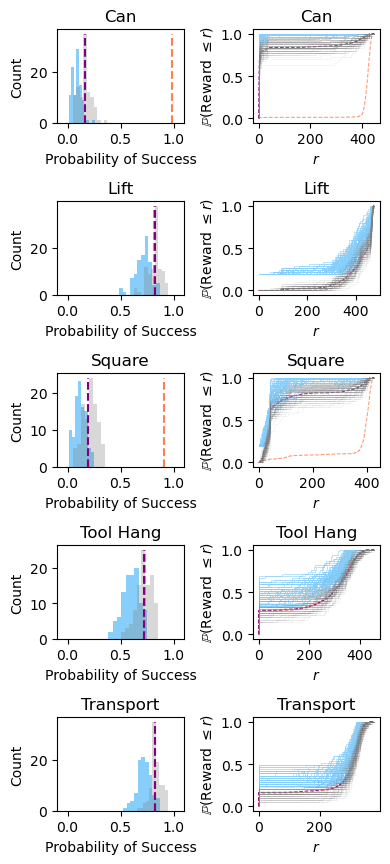

In [21]:
from binomial_cis import expected_shortage
from binomial_cis.conf_intervals import llc_accept_prob

def get_title(task):
    if task == "can":
        title = "Can"
    elif task == "lift":
        title = "Lift"
    elif task == "square":
        title = "Square"
    elif task == "tool_hang":
        title = "Tool Hang"
    elif task == "transport":
        title = "Transport"
    return title


n = 40
alpha = 0.05
print("# bounds:", 4000/n)


plt.figure(figsize=(4,1.75*5))
for iter,task in enumerate(["can", "lift", "square", "tool_hang", "transport"]):
    # get data
    rewards_calib, rewards_conf, rewards_id = get_data(task)
    cont_rewards_calib, cont_rewards_conf, cont_rewards_id, binary_rewards_calib, binary_rewards_conf, binary_rewards_id, max_reward = format_data(rewards_calib, rewards_conf, rewards_id)
    CDF_xs, CDF_ys, CDF_xs_id, CDF_ys_id = estimate_true(cont_rewards_calib, cont_rewards_id, binary_rewards_calib, binary_rewards_id, max_reward)
    CDF_bound_xs, CDF_ubs, lbs = compute_bounds(cont_rewards_conf, binary_rewards_conf, max_reward, n, alpha)
    ES = expected_shortage(llc_accept_prob, alpha, n, np.mean(binary_rewards_calib))
    title = get_title(task)

    # get mc estimates
    CDF_mc_xs, CDF_mc_ubs, p_hats = compute_mc_ests(cont_rewards_conf, binary_rewards_conf, max_reward, n)

    # print empirical results
    avg_coverage, avg_excess_len = analyze_binom_bounds(binary_rewards_calib, lbs)
    avg_coverage_cdf = analyze_cdf_bounds(CDF_xs, CDF_ys, CDF_bound_xs, CDF_ubs)
    print("\nTheoretical Coverage:     ", 1-alpha)
    print("Binomial Average Coverage:", avg_coverage)
    print("CDF Average Coverage:     ", avg_coverage_cdf)
    print("Theoretical Shortage:     ", round(ES, 3))
    print("Binomial Average Shortage:", round(avg_excess_len, 3))

    # binary plots
    plt.subplot(5, 2, 2*iter+1)
    y, x, _ = plt.hist(lbs, bins='auto', color="lightskyblue")
    y_mc, x_mc, _ = plt.hist(p_hats, bins='auto', color='grey', alpha=0.3)
    plt.vlines(x = np.mean(binary_rewards_id), ymin=0, ymax=max(y.max(), y_mc.max()), linestyle="dashed", color="coral", label="ID")
    plt.vlines(x = np.mean(binary_rewards_calib), ymin=0, ymax=max(y.max(), y_mc.max()), linestyle="dashed", color="purple", label="OOD")
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel('Probability of Success')
    plt.xlim(-0.1, 1.1)

    # cdf plots
    plt.subplot(5, 2, 2*iter + 2)
    plt.step(CDF_xs_id, CDF_ys_id, where="post", alpha=0.8, linestyle="dashed", color="coral", linewidth=0.75)
    plt.step(CDF_xs, CDF_ys, where="post", alpha=0.8, linestyle="dashed", color="purple", linewidth=0.75)
    for i in range(CDF_bound_xs.shape[0]):
        plt.step(CDF_bound_xs[i,:], CDF_ubs[i,:], where="post", alpha=0.8, color="lightskyblue", linewidth=.5)
    
    for i in range(CDF_bound_xs.shape[0]):
        plt.step(CDF_mc_xs[i,:], CDF_mc_ubs[i,:], where="post", alpha=0.1, color="grey", linewidth=.5)
    plt.title(title)
    plt.xlabel(r'$r$')
    plt.ylabel(r'$\mathbb{P}($Reward $\leq r)$')

plt.tight_layout()

# plt.savefig("media/all_tasks.svg")

## Plot KS vs DKW Offset

n: 5.0
n: 6.0
n: 7.0
n: 8.0
n: 9.0
n: 10.0
n: 11.0
n: 12.0
n: 13.0
n: 14.0
n: 15.0
n: 16.0
n: 17.0
n: 18.0
n: 19.0
n: 20.0
n: 21.0
n: 22.0
n: 23.0
n: 24.0
n: 25.0
n: 26.0
n: 27.0
n: 28.0
n: 29.0
n: 30.0


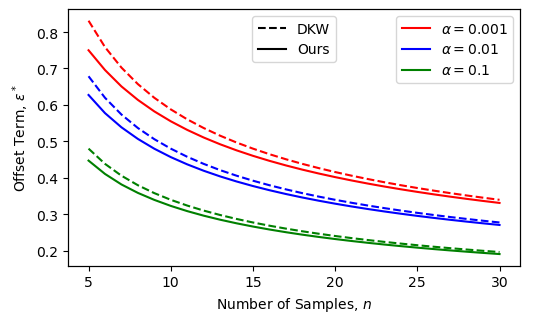

In [22]:
import matplotlib.pyplot as plt
import numpy as np

N = 30
ns = np.linspace(5, N, N-4) 
alphas = [0.001, 0.01, 0.1]
colors = ['red', 'blue', 'green', 'orange']

eps_ks  = np.zeros((len(ns), len(alphas)))
eps_dkw = np.zeros_like(eps_ks)

fig, ax = plt.subplots(figsize=(7*(2.5/3),4*(2.5/3)))

for i,n in enumerate(ns):
    print("n:", n)
    for j,alpha in enumerate(alphas):
        eps_dkw[i,j] = DKW_epsilon(n, alpha)
        eps_ks[i,j] = KS_epsilon(n, alpha)

for i,alpha in enumerate(alphas):
    ax.plot(ns, eps_ks[:, i], label=str(r"$\alpha = $" + str(alpha)), color=colors[i])
    ax.plot(ns, eps_dkw[:, i], linestyle='dashed', color=colors[i])
# ax.set_ylim(0.05,0.76)
ax.set_xlabel(r"Number of Samples, $n$")
ax.set_ylabel(r'Offset Term, $\epsilon^*$')

ax2 = ax.twinx()
ax2.plot(np.NaN, np.NaN, linestyle='--', label='DKW', c='black')

ax2.plot(np.NaN, np.NaN, linestyle='-', label='Ours', c='black')
ax2.get_yaxis().set_visible(False)

ax.legend(loc='upper right')
ax2.legend(loc='upper center')

# plt.savefig("media/cdf_eps_comparison.svg")